In [1]:
import zipfile
import tensorflow as tf
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
print (session.run(c))

[[22. 28.]
 [49. 64.]]


In [2]:
from keras.layers import *
from keras.models import *
from keras.preprocessing.image import ImageDataGenerator
from keras.losses import *
from keras.optimizers import *
from keras.callbacks import *
from keras.regularizers import *
import time
import pickle
import matplotlib.pyplot as plt
import keras.backend as K
from skimage.io import imread
from skimage.transform import resize

from keras.applications.densenet import DenseNet201, preprocess_input

Using TensorFlow backend.


In [ ]:
del(encoder)
del(decoder)
del(vae)

In [8]:
# VAE model = encoder + decoder
# build encoder model
latent_dim = (18,18,64)
input_shape=(18,18,736)

def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(latent_dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def create_vae(input_shape, latent_dim):
    inputs = Input(shape=input_shape, name='encoder_input')

    x = Dense(256)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    z_mean = Dense(latent_dim[-1], name='z_mean')(x)
    z_log_var = Dense(latent_dim[-1], name='z_log_var')(x)

    z = Lambda(sampling, name='z')([z_mean, z_log_var])

    # instantiate encoder model
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    encoder.summary()

    # build decoder model
    latent_inputs = Input(shape=(latent_dim), name='z_sampling')

    x = Dense(128)(latent_inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dense(736)(x)
    x = BatchNormalization()(x)
    outputs = Activation('sigmoid')(x)

    # instantiate decoder model
    decoder = Model(latent_inputs, outputs, name='decoder')
    decoder.summary()

    # instantiate VAE model
    outputs = decoder(encoder(inputs)[2])
    
    
    vae = Model(inputs, outputs, name='vae')
    
    reconstruction_loss = binary_crossentropy(inputs, outputs)
    reconstruction_loss *= 736
    
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')
    
    return vae, encoder, decoder



In [4]:
import os
from keras.preprocessing.image import ImageDataGenerator

batch_size = 16

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

root_path = '/tf/data/Quan/datasets/webcam'
train_generator = train_datagen.flow_from_directory(os.path.join(root_path, 'images'), 
                                                    class_mode='categorical', 
                                                    target_size=(300,300), 
                                                    batch_size=batch_size, 
                                                    shuffle=True)

validation_generator = test_datagen.flow_from_directory(os.path.join(root_path, 'val_images'), 
                                                        class_mode='categorical', 
                                                        target_size=(300,300), 
                                                        batch_size=batch_size, 
                                                        shuffle=False)

test_generator = test_datagen.flow_from_directory(os.path.join(root_path, 'test_images'), 
                                                        class_mode='categorical', 
                                                        target_size=(300,300), 
                                                        batch_size=1, 
                                                        shuffle=False)

label_dict = test_generator.class_indices
print(label_dict)

Found 444 images belonging to 31 classes.
Found 112 images belonging to 31 classes.
Found 239 images belonging to 31 classes.
{'back_pack': 0, 'bike': 1, 'bike_helmet': 2, 'bookcase': 3, 'bottle': 4, 'calculator': 5, 'desk_chair': 6, 'desk_lamp': 7, 'desktop_computer': 8, 'file_cabinet': 9, 'headphones': 10, 'keyboard': 11, 'laptop_computer': 12, 'letter_tray': 13, 'mobile_phone': 14, 'monitor': 15, 'mouse': 16, 'mug': 17, 'paper_notebook': 18, 'pen': 19, 'phone': 20, 'printer': 21, 'projector': 22, 'punchers': 23, 'ring_binder': 24, 'ruler': 25, 'scissors': 26, 'speaker': 27, 'stapler': 28, 'tape_dispenser': 29, 'trash_can': 30}


## Training original amazon

In [13]:
def create_model(input_shape=(300,300,3), n_classes=31):

    input_model = Input(shape=input_shape)

    x = Conv2D(64, (3,3), padding='same')(input_model)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = Conv2D(128, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = Conv2D(256, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

#     x = Conv2D(512, (3,3), padding='same')(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     x = Conv2D(512, (3,3), padding='same')(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     x = Conv2D(512, (3,3), padding='same')(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     x = MaxPooling2D(pool_size=(2,2))(x)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(n_classes)(x)
    x = BatchNormalization()(x)
    x = Activation('softmax')(x)

    return Model(inputs=input_model, outputs=x)

In [10]:
baseline_model = create_model(input_shape=(256,256,3))
baseline_model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
baseline_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 256, 256, 64)      1792      
_________________________________________________________________
batch_normalization_9 (Batch (None, 256, 256, 64)      256       
_________________________________________________________________
activation_9 (Activation)    (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
batch_normalization_10 (Batc (None, 256, 256, 64)      256       
_________________________________________________________________
activation_10 (Activation)   (None, 256, 256, 64)      0   

## Training baseline amazon 

In [11]:
batch_size=32
mcp = ModelCheckpoint('/tf/data/Quan/tf_models/amazon_phase2/baseline_model.hdf5', monitor='val_accuracy', 
                      save_best_only=True, save_weights_only=False)

start = time.time()

history = baseline_model.fit_generator(train_generator, steps_per_epoch=len(train_generator.filenames) // batch_size,
                                      validation_data=validation_generator,
                                      validation_steps=len(validation_generator) // batch_size,
                                      epochs=100, callbacks=[mcp], verbose=1)

exe_time = time.time() - start
history.history['exe_time'] = exe_time

print('exe time: ', exe_time)
with open('/tf/data/Quan/tf_models/amazon_phase2/baseline_history.hdf5', 'wb') as dt:
    pickle.dump(history.history, dt)
    

Epoch 1/100
49/49 [==============================] - 21s 432ms/step - loss: 3.3847 - accuracy: 0.0855 - val_loss: 7.6963 - val_accuracy: 0.0430
Epoch 2/100
49/49 [==============================] - 20s 405ms/step - loss: 3.1011 - accuracy: 0.1133 - val_loss: 2.9412 - val_accuracy: 0.0506
Epoch 3/100
49/49 [==============================] - 20s 407ms/step - loss: 3.0032 - accuracy: 0.1574 - val_loss: 2.1979 - val_accuracy: 0.0228
Epoch 4/100
49/49 [==============================] - 20s 407ms/step - loss: 2.8749 - accuracy: 0.1878 - val_loss: 2.6850 - val_accuracy: 0.0228
Epoch 5/100
49/49 [==============================] - 20s 408ms/step - loss: 2.8217 - accuracy: 0.2222 - val_loss: 2.2378 - val_accuracy: 0.0304
Epoch 6/100
49/49 [==============================] - 20s 408ms/step - loss: 2.7470 - accuracy: 0.2332 - val_loss: 2.3953 - val_accuracy: 0.0304
Epoch 7/100
49/49 [==============================] - 20s 409ms/step - loss: 2.6485 - accuracy: 0.2701 - val_loss: 2.5259 - val_accuracy:

In [14]:
baseline_model = load_model('/tf/data/Quan/tf_models/amazon_phase2/baseline_model.hdf5')
# score = baseline_model.evaluate_generator(test_generator, verbose=1)
# score

Instructions for updating:
If using Keras pass *_constraint arguments to layers.




## Feature extractor amazon for webcam dataset

In [54]:
baseline_model = load_model('/tf/data/Quan/tf_models/amazon_phase2/baseline_model.hdf5')
baseline_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 256, 256, 64)      1792      
_________________________________________________________________
batch_normalization_9 (Batch (None, 256, 256, 64)      256       
_________________________________________________________________
activation_9 (Activation)    (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
batch_normalization_10 (Batc (None, 256, 256, 64)      256       
_________________________________________________________________
activation_10 (Activation)   (None, 256, 256, 64)      0   

In [66]:
_in = Input(shape=(300,300,3))
baseline_model.trainable=True
for i in range(0, 25):
    baseline_model.layers[i].trainable = False

baseline_model.compile(loss=categorical_crossentropy, optimizer=Adam(0.0005), metrics=['accuracy'])
baseline_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv0_block0 (Conv2D)           (None, 300, 300, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batchnorm0_block0 (BatchNormali (None, 300, 300, 32) 128         conv0_block0[0][0]               
__________________________________________________________________________________________________
relu0_block0 (Activation)       (None, 300, 300, 32) 0           batchnorm0_block0[0][0]          
____________________________________________________________________________________________

In [52]:
extractor.layers[1].layers[24]

In [61]:
baseline_model = load_model('/tf/data/Quan/tf_models/amazon/baseline_model.hdf5')

batch_size=32
mcp = ModelCheckpoint('/tf/data/Quan/tf_models/webcam_phase2/amazon_extractor_model.hdf5', monitor='val_accuracy', 
                      save_best_only=True, save_weights_only=False)

start = time.time()

history = extractor.fit_generator(train_generator, steps_per_epoch=len(train_generator.filenames) // batch_size,
                                      validation_data=validation_generator,
                                      validation_steps=len(validation_generator) // batch_size,
                                      epochs=100, callbacks=[mcp], verbose=1)

exe_time = time.time() - start
history.history['exe_time'] = exe_time

print('exe time: ', exe_time)
with open('/tf/data/Quan/tf_models/webcam_phase2/amazon_extractor_history.hdf5', 'wb') as dt:
    pickle.dump(history.history, dt)

Epoch 1/100
13/13 [==============================] - 4s 323ms/step - loss: 4.4286 - val_loss: 3.5301
Epoch 2/100
 3/13 [=====>........................] - ETA: 0s - loss: 4.5994

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_accuracy available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


13/13 [==============================] - 1s 97ms/step - loss: 4.2505 - val_loss: 3.5301
Epoch 3/100
13/13 [==============================] - 1s 87ms/step - loss: 4.4010 - val_loss: 3.5301
Epoch 4/100
13/13 [==============================] - 1s 97ms/step - loss: 4.1681 - val_loss: 3.5301
Epoch 5/100
13/13 [==============================] - 1s 87ms/step - loss: 4.3264 - val_loss: 3.5301
Epoch 6/100
13/13 [==============================] - 1s 95ms/step - loss: 4.3726 - val_loss: 3.5301
Epoch 7/100
13/13 [==============================] - 1s 89ms/step - loss: 4.2676 - val_loss: 3.5301
Epoch 8/100
13/13 [==============================] - 1s 92ms/step - loss: 4.4397 - val_loss: 3.5301
Epoch 9/100
13/13 [==============================] - 1s 96ms/step - loss: 4.1118 - val_loss: 3.5301
Epoch 10/100
13/13 [==============================] - 1s 92ms/step - loss: 4.1291 - val_loss: 3.5301
Epoch 11/100
12/13 [==========================>...] - ETA: 0s - loss: 4.1374

KeyboardInterrupt: 

## Fine tunning amazon for webcam dataset

In [4]:
baseline_model = load_model('/tf/data/Quan/tf_models/amazon/baseline_model.hdf5')

batch_size=32
mcp = ModelCheckpoint('/tf/data/Quan/tf_models/webcam_phase2/finetune_model.hdf5', monitor='val_accuracy', 
                      save_best_only=True, save_weights_only=False)

start = time.time()

history = baseline_model.fit_generator(train_generator, steps_per_epoch=len(train_generator.filenames) // batch_size,
                                      validation_data=validation_generator,
                                      validation_steps=len(validation_generator) // batch_size,
                                      epochs=100, callbacks=[mcp], verbose=1)

exe_time = time.time() - start
history.history['exe_time'] = exe_time

print('exe time: ', exe_time)
with open('/tf/data/Quan/tf_models/webcam_phase2/finetune_history.hdf5', 'wb') as dt:
    pickle.dump(history.history, dt)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Epoch 1/100
13/13 [==============================] - 7s 552ms/step - loss: 3.1973 - accuracy: 0.2308 - val_loss: 15.3368 - val_accuracy: 0.1250
Epoch 2/100
13/13 [==============================] - 5s 360ms/step - loss: 2.4200 - accuracy: 0.3873 - val_loss: 44.5931 - val_accuracy: 0.0982
Epoch 3/100
13/13 [==============================] - 3s 209ms/step - loss: 1.6590 - accuracy: 0.4471 - val_loss: 35.0951 - val_accuracy: 0.0893
Epoch 4/100
13/13 [==============================] - 3s 206ms/step - loss: 1.6978 - accuracy: 0.4706 - val_loss: 13.4538 - val_accuracy: 0.1875
Epoch 5/100
13/13 [==============================] - 3s 209ms/step - loss: 1.1820 - accuracy: 0.6683 - val_loss: 36.0146 - val_accuracy: 0.0804
Epoch 6/100
13/13 [==============================] - 3s 205ms/step - loss: 1.3102 - accuracy: 0.6275 - val_loss: 14.5357 - val_accuracy: 0.2589
Epoch 7/100
13/13 [==============================] - 

Epoch 53/100
13/13 [==============================] - 3s 209ms/step - loss: 0.3699 - accuracy: 0.9608 - val_loss: 1.4266 - val_accuracy: 0.8214
Epoch 54/100
13/13 [==============================] - 3s 209ms/step - loss: 0.3655 - accuracy: 0.9615 - val_loss: 0.7532 - val_accuracy: 0.9107
Epoch 55/100
13/13 [==============================] - 3s 212ms/step - loss: 0.3799 - accuracy: 0.9327 - val_loss: 1.0075 - val_accuracy: 0.8214
Epoch 56/100
13/13 [==============================] - 3s 205ms/step - loss: 0.3852 - accuracy: 0.9265 - val_loss: 1.0856 - val_accuracy: 0.8125
Epoch 57/100
13/13 [==============================] - 3s 209ms/step - loss: 0.3482 - accuracy: 0.9706 - val_loss: 0.9824 - val_accuracy: 0.8661
Epoch 58/100
13/13 [==============================] - 3s 209ms/step - loss: 0.3913 - accuracy: 0.9327 - val_loss: 0.8495 - val_accuracy: 0.8661
Epoch 59/100
13/13 [==============================] - 3s 209ms/step - loss: 0.3496 - accuracy: 0.9363 - val_loss: 1.1351 - val_accuracy:

In [6]:
test_model = load_model('/tf/data/Quan/tf_models/webcam_phase2/finetune_model.hdf5')
score = test_model.evaluate_generator(test_generator, verbose=1)
score

239/239 [==============================] - 3s 11ms/step


[0.07255211472511292, 0.8912134170532227]

In [15]:
vaes = []
output_indices = [7,14, 24]
for i in output_indices:
    input_shape = baseline_model.layers[i].output_shape
    latent_dim = (18,18,input_shape[-1])
    
    vae = create_vae(input_shape, latent_dim)
    
    reconstruction_loss = input_shape * binary_crossentropy(vae.inputs,vae.outputs)
    z_log_var = vae.get_layer('encoder').get_layer('z_log_var')
    z_mean = vae.get_layer('encoder').get_layer('z_mean')
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')
    
    vaes.append(vae)


ValueError: Dimensions must be equal, but are 128 and 18 for 'z/mul_1' (op: 'Mul') with input shapes: [?,?,128,128,128], [18,18,64].

In [5]:
# create feature extractor model
output_indices = [7,14, 24]
outputs = [baseline_model.layers[k].output for k in output_indices]
extractor = Model(inputs=baseline_model.inputs, outputs=outputs)

extractor.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 256, 256, 64)      1792      
_________________________________________________________________
batch_normalization_9 (Batch (None, 256, 256, 64)      256       
_________________________________________________________________
activation_9 (Activation)    (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
batch_normalization_10 (Batc (None, 256, 256, 64)      256       
_________________________________________________________________
activation_10 (Activation)   (None, 256, 256, 64)      0   

In [6]:
# extract feature from source (amazon)
test_datagen = ImageDataGenerator(rescale=1./255)

root_path = '/tf/data/Quan/datasets/amazon'
train_feature_generator = test_datagen.flow_from_directory(os.path.join(root_path, 'images'), 
                                                    class_mode='categorical', 
                                                    target_size=(256,256), 
                                                    batch_size=1, 
                                                    shuffle=False)

validation_feature_generator = test_datagen.flow_from_directory(os.path.join(root_path, 'val_images'), 
                                                        class_mode='categorical', 
                                                        target_size=(256,256), 
                                                        batch_size=1, 
                                                        shuffle=False)

test_feature_generator = test_datagen.flow_from_directory(os.path.join(root_path, 'test_images'), 
                                                        class_mode='categorical', 
                                                        target_size=(256,256), 
                                                        batch_size=1, 
                                                        shuffle=False)

Found 1576 images belonging to 31 classes.
Found 395 images belonging to 31 classes.
Found 846 images belonging to 31 classes.


In [ ]:
strain_features = extractor.predict_generator(train_feature_generator, verbose=1)
with open('/tf/data/Quan/tf_models/amazon_phase2/train_extracted_features.hdf5', 'wb') as dt:
    pickle.dump(strain_features, dt)
# sval_features = extractor.predict_generator(validation_feature_generator, verbose=1)
# stest_features = extractor.predict_generator(test_feature_generator, verbose=1)

1576/1576 [==============================] - 19s 12ms/step


In [ ]:
del(strain_features)

In [ ]:
strain_features = extractor.predict_generator(train_feature_generator, verbose=1)
with open('/tf/data/Quan/tf_models/amazon_phase2/train_extracted_features.hdf5', 'wb') as dt:
    pickle.dump(strain_features, dt)

In [9]:
with open('/tf/data/Quan/tf_models/amazon/extracted_features.hdf5', 'rb') as dt:
    s_labels, s_features = pickle.load(dt)
    
with open('/tf/data/Quan/tf_models/amazon/val_extracted_features.hdf5', 'rb') as dt:
    sval_labels, sval_features = pickle.load(dt)
    
with open('/tf/data/Quan/tf_models/webcam/extracted_features.hdf5', 'rb') as dt:
    t_labels, t_features = pickle.load(dt)
    
with open('/tf/data/Quan/tf_models/webcam/val_extracted_features.hdf5', 'rb') as dt:
    tval_labels, tval_features = pickle.load(dt)

with open('/tf/data/Quan/tf_models/webcam/t_test_features.hdf5', 'rb') as dt:
    ttest_labels, ttest_features = pickle.load(dt)

# s_labels = [k.split('/')[-2] for k in s_labels]
# sval_labels = [k.split('/')[-2] for k in sval_labels]

t_labels = [k.split('/')[-2] for k in t_labels]
tval_labels = [k.split('/')[-2] for k in tval_labels]
    
# s_features.shape, sval_features.shape, t_features.shape

In [16]:
vae.inputs, vae.outputs

([<tf.Tensor 'encoder_input_3:0' shape=(?, 18, 18, 736) dtype=float32>],
 [<tf.Tensor 'decoder_3/batch_normalization_20/cond/Merge:0' shape=(?, 18, 18, 736) dtype=float32>])

## Amazon

In [10]:
vae, _, _ = create_vae(input_shape=(18,18,736), latent_dim=(18,18,64))

batch_size=32
mcp = ModelCheckpoint('/tf/data/Quan/tf_models/amazon_phase2/vae_2_model_weights.hdf5', monitor='val_loss', 
                      save_best_only=True, save_weights_only=True)

start = time.time()
history = vae.fit(s_features, batch_size=batch_size, epochs=100, 
          validation_data=(sval_features, None), callbacks=[mcp], verbose=1)

exe_time = time.time() - start

print('exe time: ', exe_time)
with open('/tf/data/Quan/tf_models/amazon_phase2/vae_2_history.hdf5', 'wb') as dt:
    pickle.dump(history.history, dt)
    

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 18, 18, 736)  0                                            
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 18, 18, 256)  188672      encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_11 (BatchNo (None, 18, 18, 256)  1024        dense_11[0][0]                   
__________________________________________________________________________________________________
activation_11 (Activation)      (None, 18, 18, 256)  0           batch_normalization_11[0][0]     
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 1576 samples, validate on 395 samples
Epoch 1/100
1576/1576 [==============================] - 3s 2ms/step - loss: 251.4673 - val_loss: -323.6046
Epoch 2/100
1576/1576 [==============================] - 2s 1ms/step - loss: 82.0494 - val_loss: -308.1350
Epoch 3/100
1576/1576 [==============================] - 2s 1ms/step - loss: 19.9334 - val_loss: -275.0741
Epoch 4/100
1576/1576 [==============================] - 2s 1ms/step - loss: -30.3252 - val_loss: -283.0990
Epoch 5/100
1576/1576 [==============================] - 2s 1ms/step - loss: -73.8288 - val_loss: -309.2905
Epoch 6/100
1576/1576 [==============================] - 2s 1ms/step - loss: -114.7015 - val_loss: -336.5271
Epoch 7/100
1576/1576 [==============================] - 2s 1ms/step - loss: -153.7659 - val_loss: -359.2448
Epoch 8/100
1576/1576 [==============================] - 2s 1ms/step - loss: -193.1869 - val_loss: -413.1765
Epoch 9/100
1576/1576 [==============================] - 2s 1ms/step - loss: -228.7068 -

1576/1576 [==============================] - 2s 1ms/step - loss: -2056.3874 - val_loss: -2553.1618
Epoch 75/100
1576/1576 [==============================] - 2s 1ms/step - loss: -2078.4790 - val_loss: -2589.1718
Epoch 76/100
1576/1576 [==============================] - 2s 1ms/step - loss: -2112.2062 - val_loss: -2629.9509
Epoch 77/100
1576/1576 [==============================] - 2s 1ms/step - loss: -2139.2449 - val_loss: -2641.8049
Epoch 78/100
1576/1576 [==============================] - 2s 1ms/step - loss: -2164.0117 - val_loss: -2669.1219
Epoch 79/100
1576/1576 [==============================] - 2s 1ms/step - loss: -2189.6766 - val_loss: -2702.7608
Epoch 80/100
1576/1576 [==============================] - 2s 1ms/step - loss: -2214.3533 - val_loss: -2741.5404
Epoch 81/100
1576/1576 [==============================] - 2s 1ms/step - loss: -2241.3922 - val_loss: -2724.7931
Epoch 82/100
1576/1576 [==============================] - 2s 1ms/step - loss: -2264.3363 - val_loss: -2758.9631
Epoch

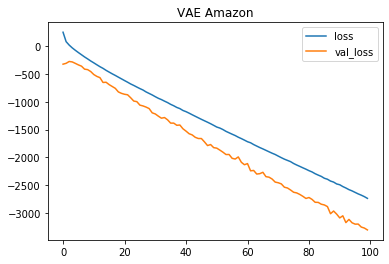

In [11]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('VAE Amazon')
plt.show()

## Webcam

In [12]:
vae, _, _ = create_vae(input_shape=(18,18,736), latent_dim=(18,18,64))

batch_size=32
mcp = ModelCheckpoint('/tf/data/Quan/tf_models/webcam_phase2/vae_2_model_weights.hdf5', monitor='val_loss', 
                      save_best_only=True, save_weights_only=True)

start = time.time()
history = vae.fit(t_features, batch_size=batch_size, epochs=100, 
          validation_data=(tval_features, None), callbacks=[mcp], verbose=1)

exe_time = time.time() - start

print('exe time: ', exe_time)
with open('/tf/data/Quan/tf_models/webcam_phase2/vae_2_history.hdf5', 'wb') as dt:
    pickle.dump(history.history, dt)
    

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 18, 18, 736)  0                                            
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 18, 18, 256)  188672      encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 18, 18, 256)  1024        dense_16[0][0]                   
__________________________________________________________________________________________________
activation_16 (Activation)      (None, 18, 18, 256)  0           batch_normalization_16[0][0]     
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 444 samples, validate on 112 samples
Epoch 1/100
444/444 [==============================] - 1s 3ms/step - loss: 509.9837 - val_loss: 529.1593
Epoch 2/100
444/444 [==============================] - 1s 1ms/step - loss: 339.8696 - val_loss: 324.5626
Epoch 3/100
444/444 [==============================] - 0s 1ms/step - loss: 262.4472 - val_loss: 220.3833
Epoch 4/100
444/444 [==============================] - 1s 1ms/step - loss: 217.1182 - val_loss: 156.8841
Epoch 5/100
444/444 [==============================] - 1s 1ms/step - loss: 186.1818 - val_loss: 120.2407
Epoch 6/100
444/444 [==============================] - 0s 1ms/step - loss: 161.7901 - val_loss: 96.2596
Epoch 7/100
444/444 [==============================] - 0s 1ms/step - loss: 143.4091 - val_loss: 71.4116
Epoch 8/100
444/444 [==============================] - 0s 1ms/step - loss: 127.0995 - val_loss: 49.3611
Epoch 9/100
444/444 [==============================] - 0s 1ms/step - loss: 111.0231 - val_loss: 31.1139
Epoch 10/100


444/444 [==============================] - 1s 1ms/step - loss: -391.0511 - val_loss: -455.6247
Epoch 78/100
444/444 [==============================] - 1s 1ms/step - loss: -400.1094 - val_loss: -454.5578
Epoch 79/100
444/444 [==============================] - 0s 1ms/step - loss: -406.2299 - val_loss: -463.2321
Epoch 80/100
444/444 [==============================] - 0s 1ms/step - loss: -411.9923 - val_loss: -463.2422
Epoch 81/100
444/444 [==============================] - 0s 1ms/step - loss: -420.7829 - val_loss: -485.0756
Epoch 82/100
444/444 [==============================] - 0s 1ms/step - loss: -425.4589 - val_loss: -466.0948
Epoch 83/100
444/444 [==============================] - 0s 1ms/step - loss: -429.7259 - val_loss: -479.7572
Epoch 84/100
444/444 [==============================] - 1s 1ms/step - loss: -436.7290 - val_loss: -484.1844
Epoch 85/100
444/444 [==============================] - 1s 1ms/step - loss: -437.1855 - val_loss: -491.5535
Epoch 86/100
444/444 [===================

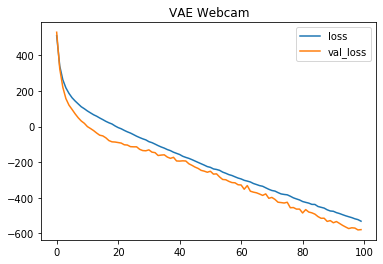

In [13]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('VAE Webcam')
plt.show()

## Combine VAE

In [14]:
import keras.losses

latent_dim = latent_dim = (18,18,64)

s_vae, _, _ = create_vae(input_shape=(18,18,736), latent_dim=(18,18,64))
s_vae.load_weights('/tf/data/Quan/tf_models/amazon_phase2/vae_2_model_weights.hdf5')
t_vae, _, _ = create_vae(input_shape=(18,18,736), latent_dim=(18,18,64))
t_vae.load_weights('/tf/data/Quan/tf_models/webcam_phase2/vae_2_model_weights.hdf5')


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 18, 18, 736)  0                                            
__________________________________________________________________________________________________
dense_21 (Dense)                (None, 18, 18, 256)  188672      encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_21 (BatchNo (None, 18, 18, 256)  1024        dense_21[0][0]                   
__________________________________________________________________________________________________
activation_21 (Activation)      (None, 18, 18, 256)  0           batch_normalization_21[0][0]     
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 18, 18, 736)  0                                            
__________________________________________________________________________________________________
dense_26 (Dense)                (None, 18, 18, 256)  188672      encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_26 (BatchNo (None, 18, 18, 256)  1024        dense_26[0][0]                   
__________________________________________________________________________________________________
activation_26 (Activation)      (None, 18, 18, 256)  0           batch_normalization_26[0][0]     
____________________________________________________________________________________________

In [15]:
t_encoder = Model(t_vae.get_layer('encoder').inputs, t_vae.get_layer('encoder').outputs, name='t_encoder')
s_decoder = Model(s_vae.get_layer('decoder').inputs, s_vae.get_layer('decoder').outputs, name='s_decoder')

In [16]:
c_vae_outputs = s_decoder(t_encoder(t_encoder.inputs)[2])
c_vae = Model(t_encoder.inputs, c_vae_outputs, name='combined_vae')
c_vae.summary()

Model: "combined_vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 18, 18, 736)       0         
_________________________________________________________________
t_encoder (Model)            [(None, 18, 18, 64), (Non 239616    
_________________________________________________________________
s_decoder (Model)            (None, 18, 18, 736)       234976    
Total params: 474,592
Trainable params: 471,584
Non-trainable params: 3,008
_________________________________________________________________


In [17]:
t_num_labels = [label_dict[k] for k in t_labels]
tval_num_labels = [label_dict[k] for k in tval_labels]
ttest_num_labels = [label_dict[k] for k in ttest_labels]

t_num_labels = keras.utils.to_categorical(t_num_labels, 31)
tval_num_labels = keras.utils.to_categorical(tval_num_labels, 31)
ttest_num_labels = keras.utils.to_categorical(ttest_num_labels, 31)

transform_features = c_vae.predict(t_features, verbose=1)
val_transform_features = c_vae.predict(tval_features, verbose=1)
test_transform_features = c_vae.predict(ttest_features, verbose=1)

239/239 [==============================] - 0s 936us/step


In [ ]:
transform_features.shape

In [18]:
baseline_model = load_model('/tf/data/Quan/tf_models/amazon/baseline_model.hdf5')

In [19]:

# retrain source classifier
c_vae.trainable=False

input_model = Input(shape=(18,18,736))

# add combined vae
t = c_vae(input_model)
residual = Add()([t, input_model])

x = BatchNormalization()(residual)
x = Activation('relu')(x)

x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(31)(x)
x = BatchNormalization()(x)
x = Activation('softmax')(x)

s_topmodel = Model(input_model, x)

s_topmodel.compile(loss='categorical_crossentropy', optimizer=Adam(0.0005), metrics=['accuracy'])

s_topmodel.layers[-2].set_weights(baseline_model.layers[-2].get_weights())
s_topmodel.layers[-3].set_weights(baseline_model.layers[-3].get_weights())

s_topmodel.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 18, 18, 736)  0                                            
__________________________________________________________________________________________________
combined_vae (Model)            (None, 18, 18, 736)  474592      input_1[0][0]                    
__________________________________________________________________________________________________
add_1 (Add)                     (None, 18, 18, 736)  0           combined_vae[1][0]               
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_31 (BatchNo (None, 18, 18, 736)  2944        add_1[0][0]                

In [29]:
baseline_model = load_model('/tf/data/Quan/tf_models/amazon/baseline_model.hdf5')

# retrain source classifier

input_model = Input(shape=(18,18,736))
x = GlobalAveragePooling2D()(input_model)
x = Dropout(0.3)(x)
x = Dense(31)(x)
x = BatchNormalization()(x)
x = Activation('softmax')(x)

s_topmodel = Model(input_model, x)

s_topmodel.compile(loss='categorical_crossentropy', optimizer=Adam(0.0005), metrics=['accuracy'])

s_topmodel.layers[-2].set_weights(baseline_model.layers[-2].get_weights())
s_topmodel.layers[-3].set_weights(baseline_model.layers[-3].get_weights())

s_topmodel.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 18, 18, 736)       0         
_________________________________________________________________
global_average_pooling2d_5 ( (None, 736)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 736)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 31)                22847     
_________________________________________________________________
batch_normalization_18 (Batc (None, 31)                124       
_________________________________________________________________
activation_8 (Activation)    (None, 31)                0         
Total params: 22,971
Trainable params: 22,909
Non-trainable params: 62
______________________________________________________

In [20]:
mcp = ModelCheckpoint('/tf/data/Quan/tf_models/webcam_phase2/amazon_vae_classifier_residual_model.hdf5', monitor='val_accuracy', 
                      save_best_only=True, save_weights_only=False)

start = time.time()
history = s_topmodel.fit(t_features, t_num_labels, batch_size=32, epochs=200,
               validation_data=(tval_features, tval_num_labels), verbose=1, callbacks=[mcp])
    
exe_time = time.time() - start
history.history['exe_time'] = exe_time

with open('/tf/data/Quan/tf_models/webcam_phase2/amazon_vae_classifier_residual_history.hdf5', 'wb') as dt:
    pickle.dump(history, dt)

print('exe time: ', exe_time)

Train on 444 samples, validate on 112 samples
Epoch 1/200
444/444 [==============================] - 1s 2ms/step - loss: 4.0041 - accuracy: 0.0856 - val_loss: 4.7408 - val_accuracy: 0.1071
Epoch 2/200
444/444 [==============================] - 0s 647us/step - loss: 2.9371 - accuracy: 0.2230 - val_loss: 3.8792 - val_accuracy: 0.1607
Epoch 3/200
444/444 [==============================] - 0s 638us/step - loss: 2.2268 - accuracy: 0.3739 - val_loss: 3.2108 - val_accuracy: 0.2143
Epoch 4/200
444/444 [==============================] - 0s 677us/step - loss: 1.6840 - accuracy: 0.5225 - val_loss: 2.6123 - val_accuracy: 0.3125
Epoch 5/200
444/444 [==============================] - 0s 709us/step - loss: 1.4006 - accuracy: 0.5991 - val_loss: 2.0984 - val_accuracy: 0.3929
Epoch 6/200
444/444 [==============================] - 0s 645us/step - loss: 1.2131 - accuracy: 0.6779 - val_loss: 1.7120 - val_accuracy: 0.5000
Epoch 7/200
444/444 [==============================] - 0s 709us/step - loss: 1.0457 - 

Epoch 57/200
444/444 [==============================] - 0s 822us/step - loss: 0.2819 - accuracy: 0.9550 - val_loss: 0.4748 - val_accuracy: 0.8750
Epoch 58/200
444/444 [==============================] - 0s 938us/step - loss: 0.2574 - accuracy: 0.9685 - val_loss: 0.4746 - val_accuracy: 0.8750
Epoch 59/200
444/444 [==============================] - 0s 708us/step - loss: 0.2390 - accuracy: 0.9707 - val_loss: 0.4755 - val_accuracy: 0.8661
Epoch 60/200
444/444 [==============================] - 0s 720us/step - loss: 0.2455 - accuracy: 0.9662 - val_loss: 0.4807 - val_accuracy: 0.8750
Epoch 61/200
444/444 [==============================] - 0s 737us/step - loss: 0.2507 - accuracy: 0.9662 - val_loss: 0.4758 - val_accuracy: 0.8839
Epoch 62/200
444/444 [==============================] - 0s 758us/step - loss: 0.2427 - accuracy: 0.9707 - val_loss: 0.4731 - val_accuracy: 0.8661
Epoch 63/200
444/444 [==============================] - 0s 761us/step - loss: 0.2140 - accuracy: 0.9752 - val_loss: 0.4671 -

444/444 [==============================] - 0s 676us/step - loss: 0.2026 - accuracy: 0.9797 - val_loss: 0.4193 - val_accuracy: 0.8929
Epoch 114/200
444/444 [==============================] - 0s 743us/step - loss: 0.1638 - accuracy: 0.9797 - val_loss: 0.4203 - val_accuracy: 0.8929
Epoch 115/200
444/444 [==============================] - 0s 835us/step - loss: 0.1814 - accuracy: 0.9842 - val_loss: 0.4208 - val_accuracy: 0.8750
Epoch 116/200
444/444 [==============================] - 0s 983us/step - loss: 0.1780 - accuracy: 0.9730 - val_loss: 0.4212 - val_accuracy: 0.8929
Epoch 117/200
444/444 [==============================] - 0s 951us/step - loss: 0.1400 - accuracy: 0.9932 - val_loss: 0.4220 - val_accuracy: 0.8839
Epoch 118/200
444/444 [==============================] - 0s 771us/step - loss: 0.1716 - accuracy: 0.9842 - val_loss: 0.4217 - val_accuracy: 0.8929
Epoch 119/200
444/444 [==============================] - 0s 985us/step - loss: 0.1640 - accuracy: 0.9842 - val_loss: 0.4174 - val_ac

Epoch 169/200
444/444 [==============================] - 0s 1ms/step - loss: 0.1078 - accuracy: 0.9887 - val_loss: 0.3997 - val_accuracy: 0.8839
Epoch 170/200
444/444 [==============================] - 0s 750us/step - loss: 0.1153 - accuracy: 0.9910 - val_loss: 0.4013 - val_accuracy: 0.8839
Epoch 171/200
444/444 [==============================] - 0s 908us/step - loss: 0.1267 - accuracy: 0.9932 - val_loss: 0.3968 - val_accuracy: 0.8839
Epoch 172/200
444/444 [==============================] - 0s 924us/step - loss: 0.1396 - accuracy: 0.9842 - val_loss: 0.3952 - val_accuracy: 0.8839
Epoch 173/200
444/444 [==============================] - 0s 698us/step - loss: 0.1561 - accuracy: 0.9775 - val_loss: 0.3913 - val_accuracy: 0.8929
Epoch 174/200
444/444 [==============================] - 0s 809us/step - loss: 0.1464 - accuracy: 0.9887 - val_loss: 0.3893 - val_accuracy: 0.8929
Epoch 175/200
444/444 [==============================] - 0s 955us/step - loss: 0.1121 - accuracy: 0.9887 - val_loss: 0.3

In [26]:
mcp = ModelCheckpoint('/tf/data/Quan/tf_models/webcam_phase2/amazon_vae_classifier_concat_model.hdf5', monitor='val_accuracy', 
                      save_best_only=True, save_weights_only=False)

start = time.time()
history = s_topmodel.fit(t_features, t_num_labels, batch_size=32, epochs=200,
               validation_data=(tval_features, tval_num_labels), verbose=1, callbacks=[mcp])
    
exe_time = time.time() - start
history.history['exe_time'] = exe_time

with open('/tf/data/Quan/tf_models/webcam_phase2/amazon_vae_classifier_concat_history.hdf5', 'wb') as dt:
    pickle.dump(history, dt)

print('exe time: ', exe_time)

Train on 444 samples, validate on 112 samples
Epoch 1/200
444/444 [==============================] - 2s 4ms/step - loss: 1.9350 - accuracy: 0.5563 - val_loss: 1.5920 - val_accuracy: 0.5804
Epoch 2/200
444/444 [==============================] - 1s 1ms/step - loss: 0.4705 - accuracy: 0.9054 - val_loss: 1.3548 - val_accuracy: 0.6607
Epoch 3/200
444/444 [==============================] - 1s 1ms/step - loss: 0.4073 - accuracy: 0.9257 - val_loss: 1.1779 - val_accuracy: 0.7143
Epoch 4/200
444/444 [==============================] - 1s 1ms/step - loss: 0.3591 - accuracy: 0.9414 - val_loss: 1.0431 - val_accuracy: 0.7411
Epoch 5/200
444/444 [==============================] - 1s 1ms/step - loss: 0.3123 - accuracy: 0.9459 - val_loss: 0.8906 - val_accuracy: 0.7500
Epoch 6/200
444/444 [==============================] - 0s 1ms/step - loss: 0.2983 - accuracy: 0.9640 - val_loss: 0.7828 - val_accuracy: 0.7857
Epoch 7/200
444/444 [==============================] - 1s 1ms/step - loss: 0.2626 - accuracy: 0.

444/444 [==============================] - 1s 1ms/step - loss: 0.1334 - accuracy: 0.9910 - val_loss: 0.5331 - val_accuracy: 0.8839
Epoch 58/200
444/444 [==============================] - 1s 1ms/step - loss: 0.1179 - accuracy: 0.9955 - val_loss: 0.5376 - val_accuracy: 0.8482
Epoch 59/200
444/444 [==============================] - 1s 1ms/step - loss: 0.1191 - accuracy: 0.9932 - val_loss: 0.5380 - val_accuracy: 0.8482
Epoch 60/200
444/444 [==============================] - 1s 1ms/step - loss: 0.1394 - accuracy: 0.9932 - val_loss: 0.6420 - val_accuracy: 0.8214
Epoch 61/200
444/444 [==============================] - 0s 1ms/step - loss: 0.1237 - accuracy: 0.9977 - val_loss: 0.5802 - val_accuracy: 0.8393
Epoch 62/200
444/444 [==============================] - 0s 1ms/step - loss: 0.0949 - accuracy: 0.9955 - val_loss: 0.5093 - val_accuracy: 0.8750
Epoch 63/200
444/444 [==============================] - 1s 1ms/step - loss: 0.0880 - accuracy: 0.9977 - val_loss: 0.5037 - val_accuracy: 0.8661
Epoch

Epoch 114/200
444/444 [==============================] - 1s 1ms/step - loss: 0.0748 - accuracy: 0.9977 - val_loss: 0.5601 - val_accuracy: 0.8482
Epoch 115/200
444/444 [==============================] - 0s 1ms/step - loss: 0.0767 - accuracy: 0.9977 - val_loss: 0.5262 - val_accuracy: 0.8482
Epoch 116/200
444/444 [==============================] - 0s 1ms/step - loss: 0.0885 - accuracy: 0.9932 - val_loss: 0.5088 - val_accuracy: 0.8571
Epoch 117/200
444/444 [==============================] - 0s 1ms/step - loss: 0.0773 - accuracy: 0.9977 - val_loss: 0.5236 - val_accuracy: 0.8750
Epoch 118/200
444/444 [==============================] - 1s 2ms/step - loss: 0.0865 - accuracy: 1.0000 - val_loss: 0.5202 - val_accuracy: 0.8571
Epoch 119/200
444/444 [==============================] - 1s 1ms/step - loss: 0.0774 - accuracy: 0.9977 - val_loss: 0.5064 - val_accuracy: 0.8571
Epoch 120/200
444/444 [==============================] - 0s 1ms/step - loss: 0.0784 - accuracy: 1.0000 - val_loss: 0.5642 - val_ac

444/444 [==============================] - 1s 1ms/step - loss: 0.0618 - accuracy: 0.9977 - val_loss: 0.5333 - val_accuracy: 0.8571
Epoch 171/200
444/444 [==============================] - 1s 1ms/step - loss: 0.0642 - accuracy: 1.0000 - val_loss: 0.5259 - val_accuracy: 0.8661
Epoch 172/200
444/444 [==============================] - 1s 1ms/step - loss: 0.0614 - accuracy: 0.9977 - val_loss: 0.4940 - val_accuracy: 0.8482
Epoch 173/200
444/444 [==============================] - 1s 1ms/step - loss: 0.0502 - accuracy: 1.0000 - val_loss: 0.4855 - val_accuracy: 0.8571
Epoch 174/200
444/444 [==============================] - 1s 2ms/step - loss: 0.0571 - accuracy: 0.9977 - val_loss: 0.4967 - val_accuracy: 0.8661
Epoch 175/200
444/444 [==============================] - 1s 1ms/step - loss: 0.0501 - accuracy: 0.9977 - val_loss: 0.4891 - val_accuracy: 0.8661
Epoch 176/200
444/444 [==============================] - 1s 1ms/step - loss: 0.0644 - accuracy: 0.9977 - val_loss: 0.4990 - val_accuracy: 0.8661

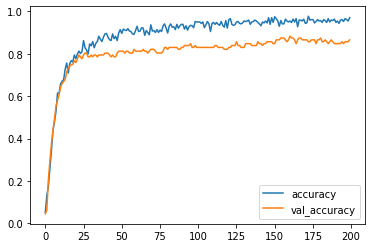

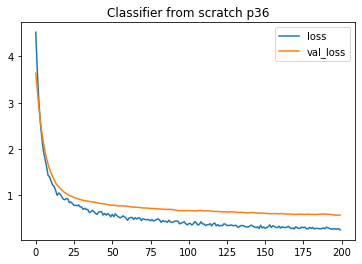

In [40]:
%matplotlib inline
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

plt.title('Classifier from scratch p36')
plt.show()

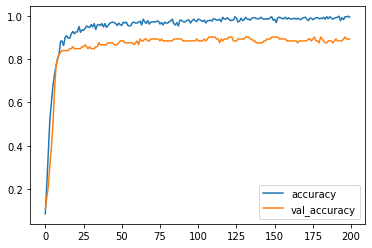

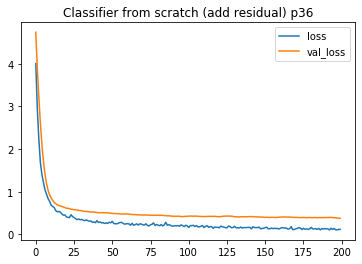

In [21]:
%matplotlib inline
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

plt.title('Classifier from scratch (add residual) p36')
plt.show()

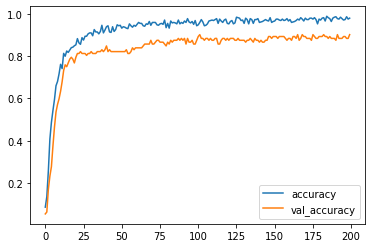

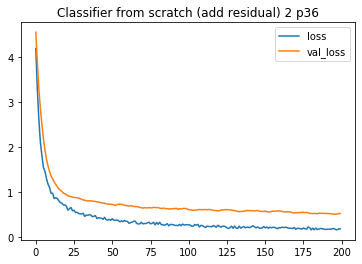

In [18]:
%matplotlib inline
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

plt.title('Classifier from scratch (add residual) 2 p36')
plt.show()

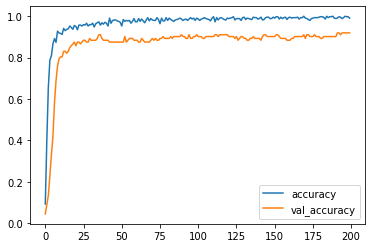

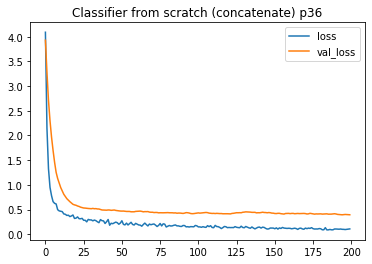

In [23]:
%matplotlib inline
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

plt.title('Classifier from scratch (concatenate) p36')
plt.show()

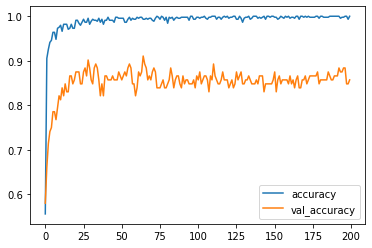

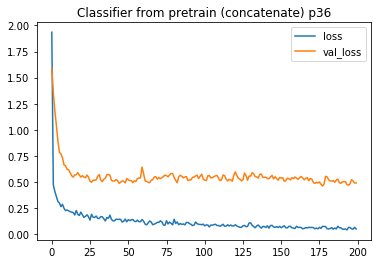

In [27]:
%matplotlib inline
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

plt.title('Classifier from pretrain (concatenate) p36')
plt.show()

In [20]:
# convention
stop_model = load_model('/tf/data/Quan/tf_models/webcam_phase2/amazon_vae_classifier_scratch_model.hdf5')
stop_model.evaluate(test_transform_features, ttest_num_labels, verbose=1)


239/239 [==============================] - 0s 2ms/step


[0.7896469669361993, 0.7949790954589844]

In [22]:
# residual
stop_model = load_model('/tf/data/Quan/tf_models/webcam_phase2/amazon_vae_classifier_scratch_residual_model.hdf5', custom_objects={'latent_dim': (18,18,64)})
stop_model.evaluate(ttest_features, ttest_num_labels, verbose=1)


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


239/239 [==============================] - 0s 2ms/step


[0.5451438444428863, 0.8619247078895569]

In [20]:
# residual 2
stop_model = load_model('/tf/data/Quan/tf_models/webcam_phase2/amazon_vae_classifier_scratch_residual_model_2.hdf5', custom_objects={'latent_dim': (18,18,64)})
stop_model.evaluate(ttest_features, ttest_num_labels, verbose=1)


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


239/239 [==============================] - 0s 2ms/step


[0.7887371504157158, 0.7866109013557434]

In [28]:
# residual without retraining
s_topmodel.evaluate(ttest_features, ttest_num_labels, verbose=1)

239/239 [==============================] - 1s 4ms/step


[4.835845385635248, 0.02092050202190876]

In [24]:
# concat
stop_model = load_model('/tf/data/Quan/tf_models/webcam_phase2/amazon_vae_classifier_scratch_concat_model.hdf5', custom_objects={'latent_dim': (18,18,64)})
stop_model.evaluate(ttest_features, ttest_num_labels, verbose=1)


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


239/239 [==============================] - 0s 2ms/step


[0.5158571648298447, 0.8702929019927979]

In [28]:
# concat with finetune
stop_model = load_model('/tf/data/Quan/tf_models/webcam_phase2/amazon_vae_classifier_concat_model.hdf5', custom_objects={'latent_dim': (18,18,64)})
stop_model.evaluate(ttest_features, ttest_num_labels, verbose=1)


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


239/239 [==============================] - 1s 3ms/step


[0.5919666564614204, 0.8619247078895569]

In [31]:
# feature extractor
stop_model = load_model('/tf/data/Quan/tf_models/webcam_phase2/amazon_extractor_model.hdf5', custom_objects={'latent_dim': (18,18,64)})
stop_model.evaluate(ttest_features, ttest_num_labels, verbose=1)


239/239 [==============================] - 0s 2ms/step


[0.5130208062327557, 0.8702929019927979]

In [ ]:
# retrain source classifier

# Get source classififer (amazon)
s_baseline = load_model('/data/Quan/tf_models/amazon/baseline_model.hdf5')
s_baseline.summary()

input_model = Input(shape=(18,18,736))
x = GlobalAveragePooling2D()(input_model)
x = Dropout(0.3)(x)
x = Dense(31)(x)
x = BatchNormalization()(x)
x = Activation('softmax')(x)

s_topmodel = Model(input_model, x)

for i in range(-3,-1):
#     print(s_topmodel.layers[i+6].name, s_baseline.layers[i].name)
    s_topmodel.layers[i].set_weights(s_baseline.layers[i].get_weights())

s_topmodel.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
s_topmodel.summary()

In [ ]:
s_topmodel.evaluate(test_transform_features, ttest_num_labels, verbose=1)

In [ ]:
mcp = ModelCheckpoint('/data/Quan/tf_models/webcam/amazon_classifier2_model.hdf5', monitor='val_acc', 
                      save_best_only=True, save_weights_only=False)

start = time.time()
history = s_topmodel.fit(transform_features, t_num_labels, batch_size=32, epochs=100,
               validation_data=(val_transform_features, tval_num_labels), verbose=1, callbacks=[mcp])

with open('/data/Quan/tf_models/webcam/amazon_classifier2_history.hdf5', 'wb') as dt:
    pickle.dump(history, dt)
    
exe_time = time.time() - start

print('exe time: ', exe_time)

In [ ]:
%matplotlib inline
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [ ]:
test_topmodel = load_model('/data/Quan/tf_models/webcam/amazon_classifier2_model.hdf5')
test_topmodel.evaluate(test_transform_features, ttest_num_labels, verbose=1)

In [33]:
baseline_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv0_block0 (Conv2D)           (None, 300, 300, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batchnorm0_block0 (BatchNormali (None, 300, 300, 32) 128         conv0_block0[0][0]               
__________________________________________________________________________________________________
relu0_block0 (Activation)       (None, 300, 300, 32) 0           batchnorm0_block0[0][0]          
____________________________________________________________________________________________